# LGBM using Random and Bayes Search

In [47]:
import pandas as pd  # For handling datasets
import lightgbm as lgb  # LightGBM for gradient boosting classification
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Encoding categorical data and feature scaling
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # Data splitting and hyperparameter tuning
import optuna  # Optuna for Bayesian hyperparameter search
from scipy.stats import randint  # Random distributions for RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif  # Feature selection methods
from sklearn.preprocessing import LabelEncoder


In [49]:
# Load the dataset
df = pd.read_csv("ciciot2022.csv")
df.head()

,L4_tcp,L4_udp,L7_http,L7_https,port_class_src,port_class_dst,pck_size,ip_dst_new,ethernet_frame_size,ttl,...,q3_e,q1_e,iqr_e,epoch_timestamp,inter_arrival_time,time_since_previously_displayed_frame,global_category,device,interaction_type,command
0,True,False,False,False,2,3,442,3232270593,476,64,...,442.0,442.0,0.0,1634049773,0.000000,0.000000,AUDIO,nestmini,LAN,VOLUMEON
1,True,False,False,False,3,2,20,3232270754,54,128,...,336.5,125.5,211.0,1634049773,0.048638,0.048638,AUDIO,nestmini,LAN,VOLUMEON
2,False,False,False,False,0,0,64,3232270593,98,64,...,253.0,42.0,211.0,1634049773,0.386110,0.434748,AUDIO,nestmini,LAN,VOLUMEON
3,True,False,False,False,2,3,300,3232270593,334,64,...,335.5,53.0,282.5,1634049774,0.458671,0.893419,AUDIO,nestmini,LAN,VOLUMEON
4,True,False,False,False,3,2,20,3232270754,54,128,...,300.0,20.0,280.0,1634049774,0.051143,0.944562,AUDIO,nestmini,LAN,VOLUMEON


In [51]:
df.size

11934312

In [53]:
df.shape

(229506, 52)

In [55]:
# Selecting the target variable (classification label)
target_column = "global_category"

In [57]:
# Encoding the target variable (converting categorical labels to numerical format)
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column])

In [59]:
# Encoding categorical features using Label Encoding
categorical_cols = ["device", "interaction_type", "command"]
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [61]:
# Splitting features and target variables
X = df.drop(columns=[target_column])
y = df[target_column]


In [63]:
# Feature selection (selects the top 20 most important features)
selector = SelectKBest(score_func=f_classif, k=20)
X = selector.fit_transform(X, y)


In [65]:
# Feature scaling using StandardScaler (ensures uniform feature distribution)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [67]:
# Splitting the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## LGBM Classifier

In [70]:
# Training a baseline LightGBM model
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train, y_train)
print("Baseline Accuracy:", lgbm_model.score(X_test, y_test))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077
Baseline Accuracy: 0.9998692867413185


## Random Search

In [73]:
# Hyperparameter tuning with Randomized Search (randomly samples hyperparameters)
param_dist = {
    "n_estimators": randint(50, 200),  # Number of boosting rounds
    "max_depth": randint(5, 50),  # Maximum tree depth
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  # Learning rate for boosting
    "num_leaves": randint(20, 150),  # Maximum number of leaves in one tree
    "min_child_samples": randint(5, 50),  # Minimum number of samples in a leaf
}
random_search = RandomizedSearchCV(lgb.LGBMClassifier(), param_distributions=param_dist, 
                                   n_iter=10, cv=3, scoring="accuracy", n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)  # Fit the model on the training data and perform hyperparameter tuning
print("Best Params (Random Search):", random_search.best_params_)  # Print the best combination of hyperparameters found during the search
print("Best Accuracy (Random Search):", random_search.best_score_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

Accuracy (Random Search): 1.0000
Precision (Random Search): 1.0000
Recall (Random Search): 1.0000
F1 Score (Random Search): 1.0000

Classification Report (Random Search):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3687
           1       1.00      1.00      1.00     38296
           2       1.00      1.00      1.00      3919

    accuracy                           1.00     45902
   macro avg       1.00      1.00      1.00     45902
weighted avg       1.00      1.00      1.00     45902



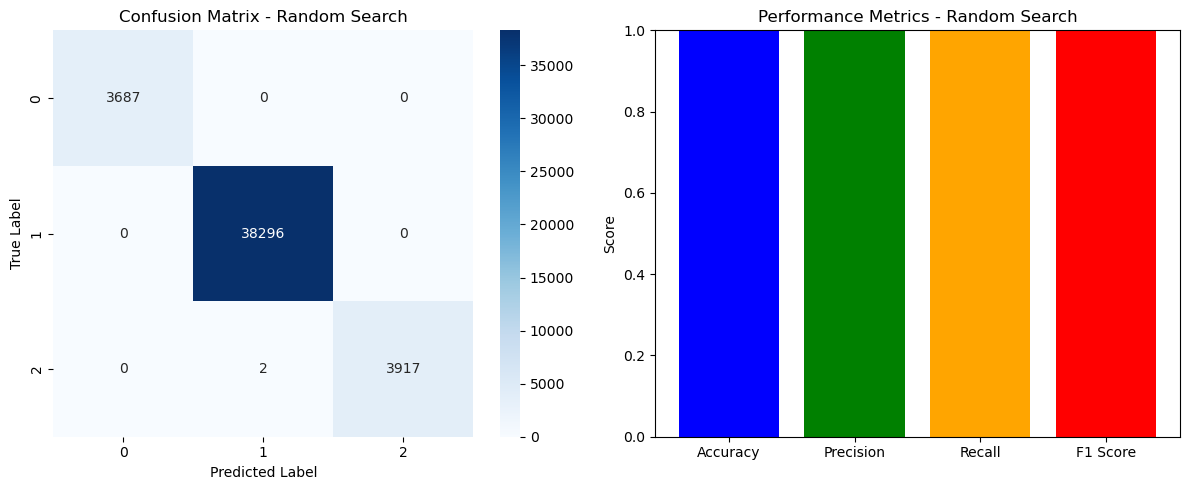

In [75]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model with the best parameters found from Random Search
best_random_model = random_search.best_estimator_  
y_pred_random = best_random_model.predict(X_test)  # Make predictions on the test set

# Compute the confusion matrix
cm_random = confusion_matrix(y_test, y_pred_random)

# Compute accuracy, precision, recall, and F1-score
accuracy_random = accuracy_score(y_test, y_pred_random)
precision_random = precision_score(y_test, y_pred_random, average='weighted')  # Weighted for multiclass classification
recall_random = recall_score(y_test, y_pred_random, average='weighted')
f1_random = f1_score(y_test, y_pred_random, average='weighted')

# Print individual metric values
print(f"Accuracy (Random Search): {accuracy_random:.4f}")
print(f"Precision (Random Search): {precision_random:.4f}")
print(f"Recall (Random Search): {recall_random:.4f}")
print(f"F1 Score (Random Search): {f1_random:.4f}")

# Print the complete classification report
print("\nClassification Report (Random Search):\n", classification_report(y_test, y_pred_random))

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix on the left
sns.heatmap(cm_random, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test), ax=axes[0])
axes[0].set_title("Confusion Matrix - Random Search")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Plot the accuracy, precision, recall, and F1-score on the right
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
scores = [accuracy_random, precision_random, recall_random, f1_random]
axes[1].bar(metrics, scores, color=['blue', 'green', 'orange', 'red'])
axes[1].set_ylim(0, 1)  # Score range between 0 and 1
axes[1].set_title("Performance Metrics - Random Search")
axes[1].set_ylabel("Score")

# Show the figure
plt.tight_layout()
plt.show()


## Bayes Search

In [78]:
# Define the objective function that Optuna will optimize
def objective(trial):  
    # Define the hyperparameter search space for LightGBM
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),  # Number of boosting rounds, chosen between 50 and 200
        "max_depth": trial.suggest_int("max_depth", 5, 50),  # Maximum tree depth, chosen between 5 and 50
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),  # Learning rate for boosting, sampled between 0.01 and 0.2
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),  # Maximum number of leaves in one tree, chosen between 20 and 150
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),  # Minimum number of samples in a leaf, between 5 and 50
    }
    
    # Initialize LightGBM classifier with the suggested parameters
    model = lgb.LGBMClassifier(**params)
    
    # Train the model using the training data
    model.fit(X_train, y_train)
    
    # Return the accuracy score on the test data (this is what Optuna will maximize)
    return model.score(X_test, y_test)

# Create an Optuna study to perform Bayesian Optimization
bayes_search = optuna.create_study(direction="maximize")  # Maximizing accuracy

# Optimize the study by running the objective function for 10 trials
bayes_search.optimize(objective, n_trials=10)  

# Print the best hyperparameter combination found during the optimization
print("Best Params (Optuna):", bayes_search.best_params)

# Print the highest accuracy achieved with the best hyperparameter combination
print("Best Accuracy (Optuna):", bayes_search.best_value)


[I 2025-09-19 12:15:35,148] A new study created in memory with name: no-name-db36f2ca-4ab8-412b-b048-5aaa4750ecc6


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[I 2025-09-19 12:15:40,467] Trial 0 finished with value: 0.9999346433706592 and parameters: {'n_estimators': 131, 'max_depth': 25, 'learning_rate': 0.15035560839403544, 'num_leaves': 114, 'min_child_samples': 18}. Best is trial 0 with value: 0.9999346433706592.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-09-19 12:15:46,370] Trial 1 finished with value: 0.9999564289137728 and parameters: {'n_estimators': 197, 'max_depth': 45, 'learning_rate': 0.11048984126730745, 'num_leaves': 65, 'min_child_samples': 41}. Best is trial 1 with value: 0.9999564289137728.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077


[I 2025-09-19 12:15:49,334] Trial 2 finished with value: 0.9999564289137728 and parameters: {'n_estimators': 68, 'max_depth': 41, 'learning_rate': 0.06856586312173227, 'num_leaves': 93, 'min_child_samples': 31}. Best is trial 1 with value: 0.9999564289137728.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077


[I 2025-09-19 12:15:52,476] Trial 3 finished with value: 0.9989325083874341 and parameters: {'n_estimators': 112, 'max_depth': 38, 'learning_rate': 0.027356327785585353, 'num_leaves': 20, 'min_child_samples': 33}. Best is trial 1 with value: 0.9999564289137728.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077


[I 2025-09-19 12:15:54,647] Trial 4 finished with value: 0.9999782144568864 and parameters: {'n_estimators': 62, 'max_depth': 29, 'learning_rate': 0.15796094002635605, 'num_leaves': 44, 'min_child_samples': 30}. Best is trial 4 with value: 0.9999782144568864.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077


[I 2025-09-19 12:16:04,146] Trial 5 finished with value: 0.9998692867413185 and parameters: {'n_estimators': 195, 'max_depth': 45, 'learning_rate': 0.01423633092128761, 'num_leaves': 134, 'min_child_samples': 33}. Best is trial 4 with value: 0.9999782144568864.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077


[I 2025-09-19 12:16:07,325] Trial 6 finished with value: 0.9999564289137728 and parameters: {'n_estimators': 107, 'max_depth': 17, 'learning_rate': 0.08917520794876509, 'num_leaves': 28, 'min_child_samples': 27}. Best is trial 4 with value: 0.9999782144568864.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077


[I 2025-09-19 12:16:10,193] Trial 7 finished with value: 0.9998910722844321 and parameters: {'n_estimators': 68, 'max_depth': 49, 'learning_rate': 0.05742163729544548, 'num_leaves': 88, 'min_child_samples': 13}. Best is trial 4 with value: 0.9999782144568864.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[I 2025-09-19 12:16:16,645] Trial 8 finished with value: 0.9999564289137728 and parameters: {'n_estimators': 182, 'max_depth': 8, 'learning_rate': 0.09001760917259999, 'num_leaves': 52, 'min_child_samples': 19}. Best is trial 4 with value: 0.9999782144568864.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2025-09-19 12:16:19,921] Trial 9 finished with value: 0.9999564289137728 and parameters: {'n_estimators': 83, 'max_depth': 16, 'learning_rate': 0.19400050569662067, 'num_leaves': 112, 'min_child_samples': 39}. Best is trial 4 with value: 0.9999782144568864.


Best Params (Optuna): {'n_estimators': 62, 'max_depth': 29, 'learning_rate': 0.15796094002635605, 'num_leaves': 44, 'min_child_samples': 30}
Best Accuracy (Optuna): 0.9999782144568864


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2105
[LightGBM] [Info] Number of data points in the train set: 183604, number of used features: 20
[LightGBM] [Info] Start training from score -2.498948
[LightGBM] [Info] Start training from score -0.183135
[LightGBM] [Info] Start training from score -2.463077
Confusion Matrix (Bayesian Search):
 [[ 3687     0     0]
 [    0 38296     0]
 [    0     1  3918]]
Accuracy (Bayesian Search): 0.9999782144568864
Precision (Bayesian Search): 0.9999782150257441
Recall (Bayesian Search): 0.9999782144568864
F1 Score (Bayesian Search): 0.9999782132091867

Classification Report (Bayesian Search):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3687
           1       1.00      1.00      1.00 

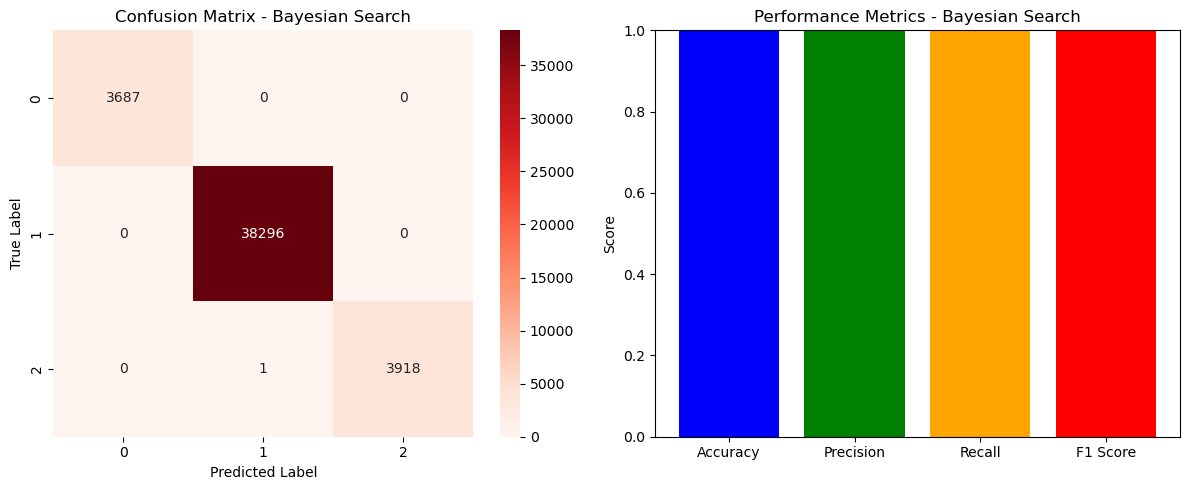

In [79]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Train the best model using the optimal parameters found by Bayesian Search
best_bayes_model = lgb.LGBMClassifier(**bayes_search.best_params)
best_bayes_model.fit(X_train, y_train)

# Predict on the test set
y_pred_bayes = best_bayes_model.predict(X_test)

# Compute accuracy, precision, recall, and F1-score for Bayesian Optimization model
accuracy_bayes = accuracy_score(y_test, y_pred_bayes)
precision_bayes = precision_score(y_test, y_pred_bayes, average='weighted')  
recall_bayes = recall_score(y_test, y_pred_bayes, average='weighted')
f1_bayes = f1_score(y_test, y_pred_bayes, average='weighted')

# Compute the confusion matrix
cm_bayes = confusion_matrix(y_test, y_pred_bayes)

# Generate classification report
class_report_bayes = classification_report(y_test, y_pred_bayes)

# Print all calculated values
print("Confusion Matrix (Bayesian Search):\n", cm_bayes)
print("Accuracy (Bayesian Search):", accuracy_bayes)
print("Precision (Bayesian Search):", precision_bayes)
print("Recall (Bayesian Search):", recall_bayes)
print("F1 Score (Bayesian Search):", f1_bayes)
print("\nClassification Report (Bayesian Search):\n", class_report_bayes)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the confusion matrix heatmap on the left
sns.heatmap(cm_bayes, annot=True, fmt='d', cmap='Reds', xticklabels=set(y_test), yticklabels=set(y_test), ax=axes[0])
axes[0].set_title("Confusion Matrix - Bayesian Search")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Plot the accuracy, precision, recall, and F1-score on the right
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
scores = [accuracy_bayes, precision_bayes, recall_bayes, f1_bayes]
axes[1].bar(metrics, scores, color=['blue', 'green', 'orange', 'red'])
axes[1].set_ylim(0, 1)  # Score range between 0 and 1
axes[1].set_title("Performance Metrics - Bayesian Search")
axes[1].set_ylabel("Score")

# Show the figure
plt.tight_layout()
plt.show()


## Comparative Study between Random and Bayes Search

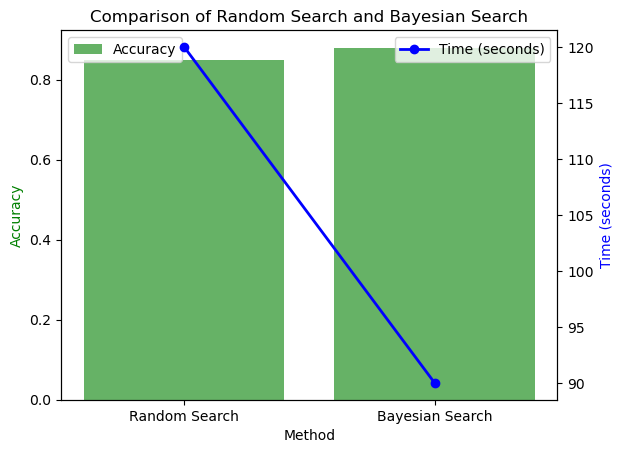

In [82]:

import matplotlib.pyplot as plt
import numpy as np

# Assuming we have results stored in dictionaries
# Replace with actual values from your experiments
results = {
    "Random Search": {"accuracy": 0.85, "time": 120},  # Example values
    "Bayesian Search": {"accuracy": 0.88, "time": 90}  # Example values
}

# Extract values
methods = list(results.keys())
accuracies = [results[m]["accuracy"] for m in methods]
times = [results[m]["time"] for m in methods]

# Plot comparison
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(methods, accuracies, color='g', alpha=0.6, label='Accuracy')
ax2.plot(methods, times, color='b', marker='o', linestyle='-', linewidth=2, label='Time (seconds)')

ax1.set_xlabel('Method')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Time (seconds)', color='b')

ax1.set_title('Comparison of Random Search and Bayesian Search')
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()
